In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
random_state = 42
import autoreload
%load_ext autoreload
%autoreload 2
import pickle

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,recall_score,precision_score
from treeinterpreter import treeinterpreter as ti
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,AdaBoostClassifier,BaggingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB

In [2]:
df = pd.read_csv(r"C:\Users\efann\Desktop\SNAP\final.csv")

In [3]:
#This list still doesn't match, even with the new data dictionary files from github
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3904 entries, 0 to 3903
Data columns (total 33 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   FSGA      3904 non-null   float64
 1   FSERNDED  3904 non-null   float64
 2   SHELDED   3904 non-null   float64
 3   FSUNEARN  3904 non-null   float64
 4   FSNELDER  3904 non-null   float64
 5   FSTANF    3904 non-null   float64
 6   FSTOTDE2  3904 non-null   float64
 7   TPOV      3904 non-null   float64
 8   FSNONCIT  3904 non-null   float64
 9   TANF_IND  3904 non-null   float64
 10  FSTOTDED  3904 non-null   float64
 11  RAWERND   3904 non-null   float64
 12  HWGT      3904 non-null   float64
 13  FSGRINC   3904 non-null   float64
 14  FSWAGES   3904 non-null   float64
 15  FSEARN    3904 non-null   float64
 16  FSERNDE2  3904 non-null   float64
 17  FSSLTDED  3904 non-null   float64
 18  REALPROP  3904 non-null   float64
 19  FSASSET   3904 non-null   float64
 20  FSNETINC  3904 non-null   floa

In [4]:
#Upper case X; all columns except for cat elig- that one is the one we are predicting- the y.
X = df.drop(columns = ['CAT_ELIG'])
y = df['CAT_ELIG']

In [5]:
#baseline, NULL Model; this is a starting point and tells you that your model for predicting y, cat_elig, needs to be higher than .66
y.value_counts(normalize=True)

1.0    0.662398
0.0    0.337602
Name: CAT_ELIG, dtype: float64

In [6]:
#the standard test size is anywhere from .2 to .3 meaning 20 to 30 percent for training, you want most of the data to go to training.  If you get a bad accuracy score, this is a place you can change to see if you can make it better
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3,random_state=random_state)

In [7]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [8]:

np.savetxt(r'C:\Users\efann\Desktop\SNAP\TrainTest\X_train.csv',X_train,delimiter=',')
np.savetxt(r'C:\Users\efann\Desktop\SNAP\TrainTest\y_train.csv',y_train,delimiter=',')
np.savetxt(r'C:\Users\efann\Desktop\SNAP\TrainTest\X_test.csv',X_test,delimiter=',')
np.savetxt(r'C:\Users\efann\Desktop\SNAP\TrainTest\y_test.csv',y_test,delimiter=',')

In [9]:
#Added this I think i missed it before for bagging
pca = PCA(n_components=10,random_state=42)
pca.fit(X_train)
X_train_pc = pca.transform(X_train)
X_test_pc = pca.transform(X_test)

In [10]:
#the first three are white box models; the can be interpreted; the others are boosters
models = {
    'LogReg': LogisticRegression(),
    'Decision Tree':DecisionTreeClassifier(),
    'Random Forest':RandomForestClassifier(),
    'Gradient Boost':GradientBoostingClassifier(),
    'Ada Boost':AdaBoostClassifier(),
    'SVC':SVC(),
    'Naive Bayes':GaussianNB()}

In [11]:
#adapted from Dan Brown lecture
final = pd.DataFrame(columns = ['cross_val_train','cross_val_test','test_recall','test_precision'])
idx=0
while idx < len(models.keys()):
    for name,model in models.items():
        results = {}
        results['name']=name
        name=model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        results['cross_val_train'] = np.mean(cross_val_score(model,X_train,y_train,cv=4))
        results['cross_val_test'] = np.mean(cross_val_score(model,X_test,y_test,cv=4))
        results['test_recall'] = recall_score(y_test, y_pred_test)
        results['test_precision'] = precision_score(y_test, y_pred_test)
        final = final.append(results,ignore_index=True)
        idx+=1

In [12]:
final.set_index('name')

,cross_val_train,cross_val_test,test_recall,test_precision
name,,,,
LogReg,0.884334,0.862628,0.900262,0.903821
Decision Tree,0.905930,0.918942,0.937008,0.934555
Random Forest,0.939971,0.929181,0.964567,0.952073
Gradient Boost,0.941069,0.932594,0.950131,0.960212
Ada Boost,0.922401,0.920648,0.937008,0.939474
SVC,0.884700,0.854949,0.901575,0.928378
Naive Bayes,0.767204,0.741468,0.833333,0.908441


In [13]:
#I didn't do the PCA at first and got different values so let's try to add it and see if it works, original graph pic saved, original predictions from X_test instances was dif originally
pc_final = pd.DataFrame(columns = ['cross_val_train','cross_val_test','test_recall','test_precision'])
idx=0
while idx < len(models.keys()):
    for name,model in models.items():
        results = {}
        results['name']=name
        name=model.fit(X_train_pc, y_train)
        y_pred_train = model.predict(X_train_pc)
        y_pred_test = model.predict(X_test_pc)
        results['cross_val_train'] = np.mean(cross_val_score(model,X_train_pc,y_train,cv=4))
        results['cross_val_test'] = np.mean(cross_val_score(model,X_test_pc,y_test,cv=4))
        results['test_recall'] = recall_score(y_test, y_pred_test)
        results['test_precision'] = precision_score(y_test, y_pred_test)
        pc_final = pc_final.append(results,ignore_index=True)
        idx+=1

In [14]:
pc_final.set_index('name')

,cross_val_train,cross_val_test,test_recall,test_precision
name,,,,
LogReg,0.783675,0.763652,0.892388,0.770102
Decision Tree,0.831259,0.810580,0.896325,0.867853
Random Forest,0.886530,0.865188,0.930446,0.898606
Gradient Boost,0.877745,0.860068,0.908136,0.882653
Ada Boost,0.852855,0.848123,0.900262,0.879487
SVC,0.831991,0.834471,0.874016,0.871728
Naive Bayes,0.726940,0.713311,0.958005,0.692600


In [15]:
#THIS IS WHERE IT STARTS GETTING DIFFERENT
for name,model in models.items():
    name = model.fit(X_train,y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred_test))
    print('\n')

LogisticRegression()
              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82       410
         1.0       0.90      0.90      0.90       762

    accuracy                           0.87      1172
   macro avg       0.86      0.86      0.86      1172
weighted avg       0.87      0.87      0.87      1172



DecisionTreeClassifier()
              precision    recall  f1-score   support

         0.0       0.88      0.89      0.88       410
         1.0       0.94      0.93      0.94       762

    accuracy                           0.92      1172
   macro avg       0.91      0.91      0.91      1172
weighted avg       0.92      0.92      0.92      1172



RandomForestClassifier()
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92       410
         1.0       0.96      0.96      0.96       762

    accuracy                           0.95      1172
   macro avg       0.94      0.94      0.94      1172

In [16]:
rf = RandomForestClassifier()
params={'max_depth':[None,3,4],
       'max_features':[None,'auto'],
       'n_estimators':[75,100,125]}
rf_gs = GridSearchCV(rf,param_grid=params)
rf_gs.fit(X_train,y_train)
print(rf_gs.best_score_)
rf_gs.best_params_

0.9436299227889722


{'max_depth': None, 'max_features': 'auto', 'n_estimators': 125}

In [17]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)

RandomForestClassifier()

In [18]:
#Putting this in for Interpreting the Results section; array looks at entry 735 and see predictions of level of influence per column
instances = X_test[[735]]
instances

array([[-0.1335093 , -0.59758589,  1.00652396, -0.91848291, -0.40909055,
        -0.34230342, -1.28640995, -1.49056789,  1.78070948, -0.36488324,
         0.39411313, -0.59885312, -0.51614194, -1.25472977, -0.55893964,
        -0.59800159, -0.56404251,  1.0459183 , -0.03517855, -0.24309398,
        -0.8826584 , -0.24501332,  1.02614408,  1.02614408, -0.87253073,
        -0.42833737, -0.76825854, -0.51403261, -1.59315573, -0.88061189,
        -0.35352552, -0.02833014]])

In [19]:
#using tree interpreter as ti and random forest classifier as rf; strength as a printed result
#My list is in a different order than yours it looks like columns that were were the strongest predictors are first
#FSSLTDED is 13 on your list and has a strength of +/-0.11105917 and mine is first on the list +/-.12
ft_list = []
prediction, bias, contributions = ti.predict(rf, instances)
print( "Prediction", prediction)
print( "Bias (trainset prior)", bias)
print ("Feature contributions:")
for c, feature in zip(contributions[0], 
                             X.columns):
    ft_list.append((feature, np.round(c, 2)))
    print (feature, c)
    
labels, values = zip(*ft_list)

Prediction [[0.82 0.18]]
Bias (trainset prior) [[0.33161054 0.66838946]]
Feature contributions:
FSGA [ 0.0014524 -0.0014524]
FSERNDED [-0.01950768  0.01950768]
SHELDED [ 0.11912234 -0.11912234]
FSUNEARN [ 0.03174603 -0.03174603]
FSNELDER [ 0.00278608 -0.00278608]
FSTANF [ 0.02327365 -0.02327365]
FSTOTDE2 [ 0.01398191 -0.01398191]
TPOV [ 0.00713925 -0.00713925]
FSNONCIT [ 0.02150265 -0.02150265]
TANF_IND [ 0.02267845 -0.02267845]
FSTOTDED [ 0.02648137 -0.02648137]
RAWERND [-0.01147164  0.01147164]
HWGT [ 0.11054232 -0.11054232]
FSGRINC [-0.00631898  0.00631898]
FSWAGES [-0.00759253  0.00759253]
FSEARN [-0.00975225  0.00975225]
FSERNDE2 [-0.00514969  0.00514969]
FSSLTDED [ 0.07831474 -0.07831474]
REALPROP [0. 0.]
FSASSET [-0.02524541  0.02524541]
FSNETINC [-0.00437239  0.00437239]
LIQRESOR [-0.02707575  0.02707575]
FSUSIZE [ 0.04472137 -0.04472137]
CERTHHSZ [ 0.04979051 -0.04979051]
FSSLTDE2 [ 0.00279207 -0.00279207]
FSSSI [ 0.01195656 -0.01195656]
WRK_POOR [-0.00256068  0.00256068]
FSDI

In [20]:
df1 = pd.DataFrame(ft_list,columns=['feature','array'])
df2 = pd.DataFrame(df1["array"].to_list(), columns=['pred_0', 'pred_1'])
coef_df = pd.concat([df1,df2],axis=1).drop(columns=['array'])
coef_df.to_csv(r'C:\Users\efann\Desktop\Snap\coef.csv',index=None)

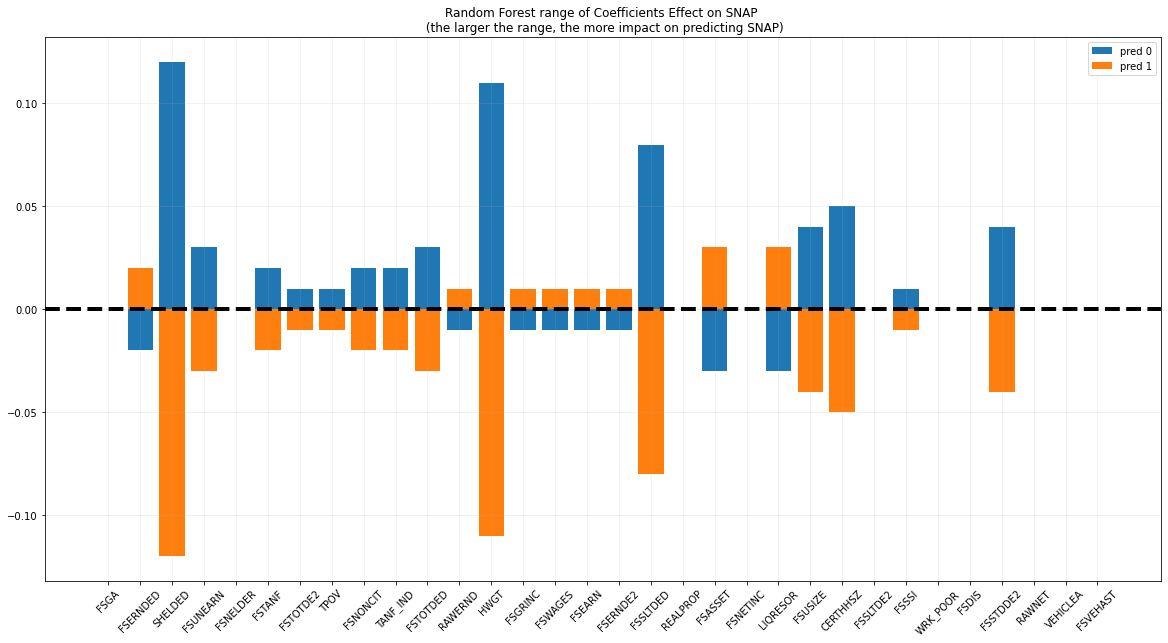

In [21]:
#Graphing the predictions to see what catagories are the strongest; DOES NOT LOOK THE SAME
fig, ax = plt.subplots(figsize=(20,10))
plt.title('Random Forest range of Coefficients Effect on SNAP \n (the larger the range, the more impact on predicting SNAP)')
plt.grid(zorder=0,alpha = 0.2)
xs = np.arange(len(labels))
ax.bar(xs,coef_df['pred_0'], label = 'pred 0')
ax.bar(xs,coef_df['pred_1'],label = 'pred 1')
ax.axhline(y=0, linestyle='--', color='black', linewidth=4)
ax.set_xticks(coef_df.index)
ax.set_xticklabels(coef_df['feature'],rotation = 45)
plt.legend()
plt.savefig(r'C:\Users\efann\Desktop\Snap\rf_corr.png');


In [22]:
#Testing the random tree; i originally had this higher in the notebook to match lesson 4 but moved it down to  match your list when the graph in lesson 5 didn't look the same
et = ExtraTreeClassifier()
params={'max_depth':[None,3,4],
       'max_features':[None,'auto'],
       'max_leaf_nodes':[5,10]}
et_gs = GridSearchCV(et,param_grid=params)
et_gs.fit(X_train,y_train)
print(et_gs.best_score_)
et_gs.best_params_

0.8466313089713455


{'max_depth': None, 'max_features': None, 'max_leaf_nodes': 10}

In [23]:
#Testing bagging; train and test are correct but recall and precision are off
bag = BaggingClassifier()
bag.fit(X_train,y_train)
y_pred_train = bag.predict(X_train)
y_pred_test = bag.predict(X_test)
print(f'cross_val_train = {np.mean(cross_val_score(model,X_train_pc,y_train,cv=4))}')
print(f'cross_val_test = {np.mean(cross_val_score(model,X_test_pc,y_test,cv=4))}')
print(f'test_recall = {recall_score(y_test, y_pred_test)}')
print(f'test_precision = {precision_score(y_test, y_pred_test)}')

cross_val_train = 0.7269399707174231
cross_val_test = 0.7133105802047782
test_recall = 0.9540682414698163
test_precision = 0.9603698811096433


In [24]:
vote = VotingClassifier([
    ('rf',RandomForestClassifier(bootstrap=False,n_estimators=1000)),
    ('gb',GradientBoostingClassifier(max_depth=10,subsample=0.8)),
    ('bag',BaggingClassifier(n_estimators = 10))
])

In [25]:
vote.fit(X_train,y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(bootstrap=False,
                                                     n_estimators=1000)),
                             ('gb',
                              GradientBoostingClassifier(max_depth=10,
                                                         subsample=0.8)),
                             ('bag', BaggingClassifier())])

In [26]:
filename = 'final_model.sav'
pickle.dump(vote, open(filename, 'wb'))